In [101]:
%matplotlib inline
from qiskit import QuantumCircuit
from qiskit.circuit.library import CSwapGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit.circuit.library import CSwapGate
import numpy as np

1 - layer QGB with inverted CNOT with controlled as 0

In [102]:
# # 1 coin qubit + 3 position qubits, 3 classical bits
# qc = QuantumCircuit(4, 3)  # q[0]=coin, q[1:4]=positions

# # Initialize ball at center position (q2)
# qc.x(2)
# # Put control qubit in superposition
# qc.h(0)

# # Controlled-SWAP operation on q1 and q2
# qc.append(CSwapGate(), [0, 1, 2])

# # Inverted CNOT (triggered when q2 == |0⟩)
# # This is equivalent to: X(q2) -> CX(q2,q0) -> X(q2) but done directly
# qc.cx(2, 0, ctrl_state='0')
# # qc.x(2)        # Flip q2 to implement ctrl_state=0
# # qc.cx(2, 0)    # Standard CNOT
# # qc.x(2)        # Flip q2 back

# # Controlled-SWAP operation on q2 and q3
# qc.append(CSwapGate(), [0, 2, 3])

# # Measure position qubits
# qc.measure(1, 0)  # q1 -> c[0]
# qc.measure(2, 1)  # q2 -> c[1] 
# qc.measure(3, 2)  # q3 -> c[2]

# # Show circuit diagram
# qc.draw('mpl')
# plt.show()

# # Simulate
# sim = AerSimulator()
# from qiskit import transpile
# compiled = transpile(qc, sim)
# result = sim.run(compiled, shots=1000).result()
# counts = result.get_counts()

# # Show result
# plot_histogram(counts)
# plt.title("1-layer QGB (measuring only left & right)")
# plt.show()

# # Print the counts to verify
# print("Measurement results:")
# for state, count in counts.items():
#     print(f"State {state}: {count} times")

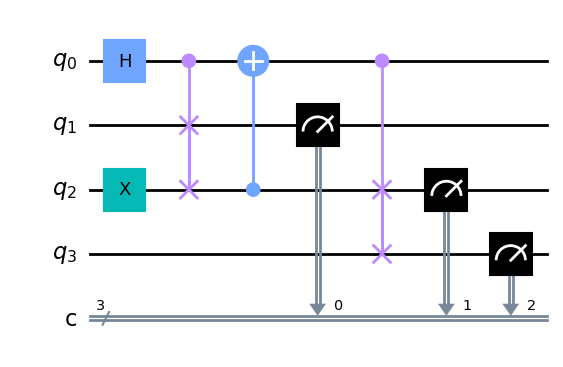

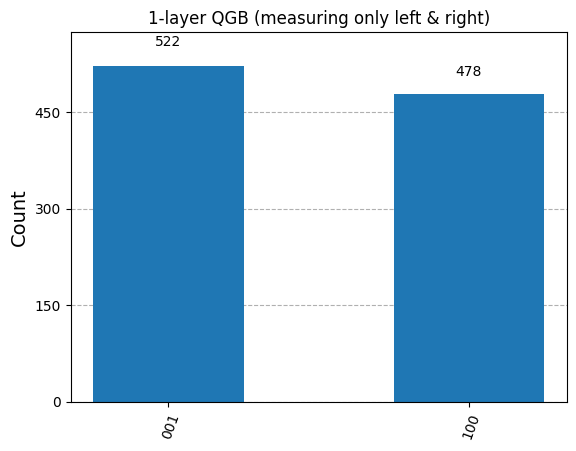

Measurement results:
State 001: 522 times
State 100: 478 times


In [103]:
# one layer QGB with CNOT as 1

qc = QuantumCircuit(4, 3)  # q[0]=coin, q[1:4]=positions

# Initialize ball at center position (q2)
qc.x(2)
# Put control qubit in superposition
qc.h(0)

# Controlled-SWAP operation on q1 and q2
qc.append(CSwapGate(), [0, 1, 2])

#Inverted CNOT 
qc.cx(2, 0) 


# Controlled-SWAP operation on q2 and q3
qc.append(CSwapGate(), [0, 2, 3])

# Measure position qubits
qc.measure(1, 0)  # q1 -> c[0]
qc.measure(2, 1)  # q2 -> c[1] 
qc.measure(3, 2)  # q3 -> c[2]

# Show circuit diagram
qc.draw(output='mpl', style='clifford', fold=1)
plt.show()

# Simulate
sim = AerSimulator()
from qiskit import transpile
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=1000).result()
counts = result.get_counts()

# Show result
plot_histogram(counts)
plt.title("1-layer QGB (measuring only left & right)")
plt.show()

# Print the counts to verify
print("Measurement results:")
for state, count in counts.items():
    print(f"State {state}: {count} times")

In [104]:
# #one layer QGB modified 
# qc = QuantumCircuit(4, 3)  # q[0]=coin, q[1:4]=positions

# # Initialize ball at center position (q2)
# qc.x(2)

# # Put control qubit in superposition
# qc.h(0)

# # Controlled-SWAP operation on q1 and q2
# qc.append(CSwapGate(), [0, 1, 2])

# # Inverted CNOT: This should flip q0 when q2 is in |0⟩ state
# # According to the paper, this creates the correct interference
# qc.x(2)        # Flip q2: |1⟩ -> |0⟩
# qc.cx(2, 0)    # CNOT: flips q0 when q2 is |1⟩ (which was originally |0⟩)
# qc.x(2)        # Flip q2 back: |0⟩ -> |1⟩
# # Apply X gate to q0 to get the correct phase relationship
# qc.x(0)
# # Controlled-SWAP operation on q2 and q3
# qc.append(CSwapGate(), [0, 2, 3])

# # Debug: Let's check the statevector
# from qiskit_aer import StatevectorSimulator
# qc_debug = qc.copy()
# sv_sim = StatevectorSimulator()
# sv_result = sv_sim.run(qc_debug).result()
# statevector = sv_result.get_statevector()

# statevector_array = np.asarray(statevector)
# print("Final statevector before measurement:")
# for i, amplitude in enumerate(statevector_array):
#     if abs(amplitude) > 1e-10:
#         binary = format(i, '04b')
#         print(f"|{binary}⟩: {amplitude:.6f}")

# # Measure position qubits
# qc.measure(1, 0)  # q1 -> c[0]
# qc.measure(2, 1)  # q2 -> c[1] 
# qc.measure(3, 2)  # q3 -> c[2]

# # Show circuit diagram
# qc.draw('mpl')
# plt.show()

# # Simulate
# sim = AerSimulator()
# compiled = transpile(qc, sim)
# result = sim.run(compiled, shots=1000).result()
# counts = result.get_counts()

# # Show result
# plot_histogram(counts)
# plt.title("1-layer QGB - Expected: 001 and 100")
# plt.show()

# # Print the counts to verify
# print("Measurement results:")
# for state, count in counts.items():
#     print(f"State {state}: {count} times")
    
# # Interpret the results
# print("\nInterpretation:")
# for state, count in counts.items():
#     q1_state = state[2]  # rightmost bit is q1
#     q2_state = state[1]  # middle bit is q2  
#     q3_state = state[0]  # leftmost bit is q3
#     if q1_state == '1':
#         print(f"Ball at LEFT position (q1): {count} times")
#     elif q2_state == '1':
#         print(f"Ball at CENTER position (q2): {count} times")
#     elif q3_state == '1':
#         print(f"Ball at RIGHT position (q3): {count} times")

2 - layer QGB without reset 0

In [105]:
# # 1 coin qubit + 5 position qubits, and 5 classical bits
# qc = QuantumCircuit(6, 5)

# # Naming: q[0] = coin, q[1]–q[5] = position qubits

# # Initial position: put particle at center (q[3])
# qc.x(3)

# # === Layer 1 ===
# qc.h(0)  # Hadamard on coin
# qc.append(CSwapGate(), [0, 2, 3]) 
# qc.cx(3, 0)
# qc.append(CSwapGate(), [0, 3, 4])  

# # === Layer 2 ===
# qc.h(0)
# qc.append(CSwapGate(), [0, 1, 2])  
# qc.cx(2, 0)
# qc.append(CSwapGate(), [0, 2, 3])   
# qc.cx(3, 0)
# qc.append(CSwapGate(), [0, 3, 4]) 
# qc.cx(4, 0)
# qc.append(CSwapGate(), [0, 4, 5]) 


# # Measure all position qubits
# qc.measure(1, 0)
# qc.measure(3, 2)
# qc.measure(5, 4)

# # Show the circuit
# qc.draw('mpl')
# plt.show()

# # Simulate
# sim = AerSimulator()
# from qiskit import transpile
# compiled = transpile(qc, sim)
# result = sim.run(compiled, shots=1000).result()
# counts = result.get_counts()
# plot_histogram(counts)
# plt.show()

2 - layer QGB with reset 0

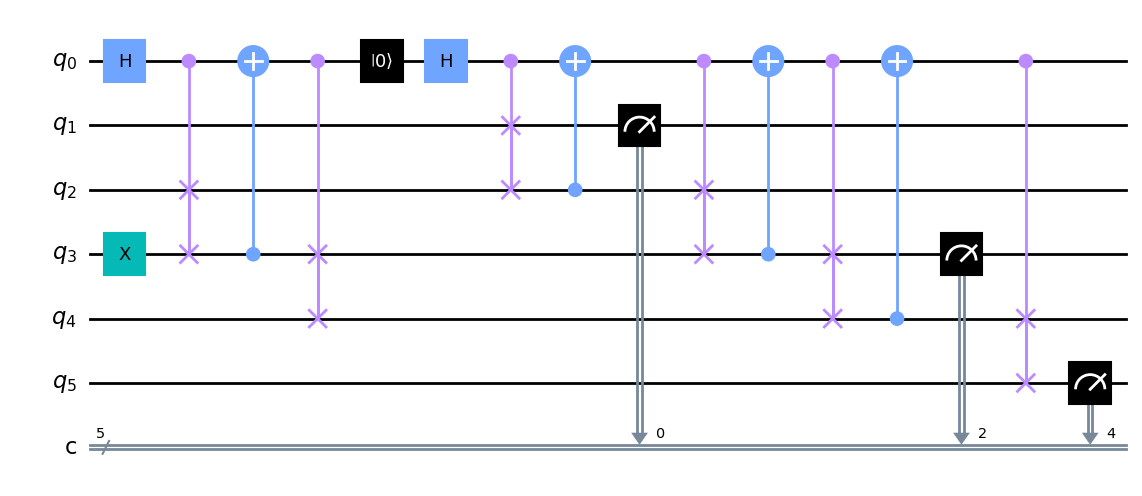

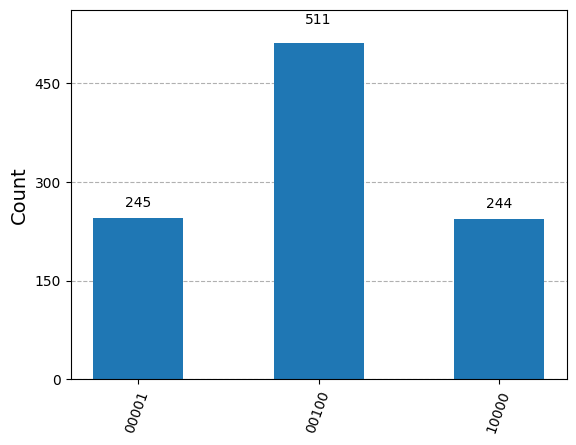

In [106]:
# 1 coin qubit + 5 position qubits, and 5 classical bits
qc = QuantumCircuit(6, 5)

# Naming: q[0] = coin, q[1]–q[5] = position qubits

# Initial position: put particle at center (q[3])
qc.x(3)

# === Layer 1 ===
qc.h(0)  # Hadamard on coin
qc.append(CSwapGate(), [0, 2, 3]) 
qc.cx(3, 0)
qc.append(CSwapGate(), [0, 3, 4])  

# === Reset coin qubit (q[0]) to |0⟩ ===
qc.reset(0)

# === Layer 2 ===
qc.h(0)
qc.append(CSwapGate(), [0, 1, 2])  
qc.cx(2, 0)
qc.append(CSwapGate(), [0, 2, 3])   
qc.cx(3, 0)
qc.append(CSwapGate(), [0, 3, 4]) 
qc.cx(4, 0)
qc.append(CSwapGate(), [0, 4, 5]) 

# Measure selected position qubits
qc.measure(1, 0)
qc.measure(3, 2)
qc.measure(5, 4)

# Show the circuit
qc.draw(output='mpl', style='clifford', fold=1)
plt.show()

# Simulate
sim = AerSimulator()
from qiskit import transpile
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=1000).result()
counts = result.get_counts()
plot_histogram(counts)
plt.show()


3 LAYER QGB 

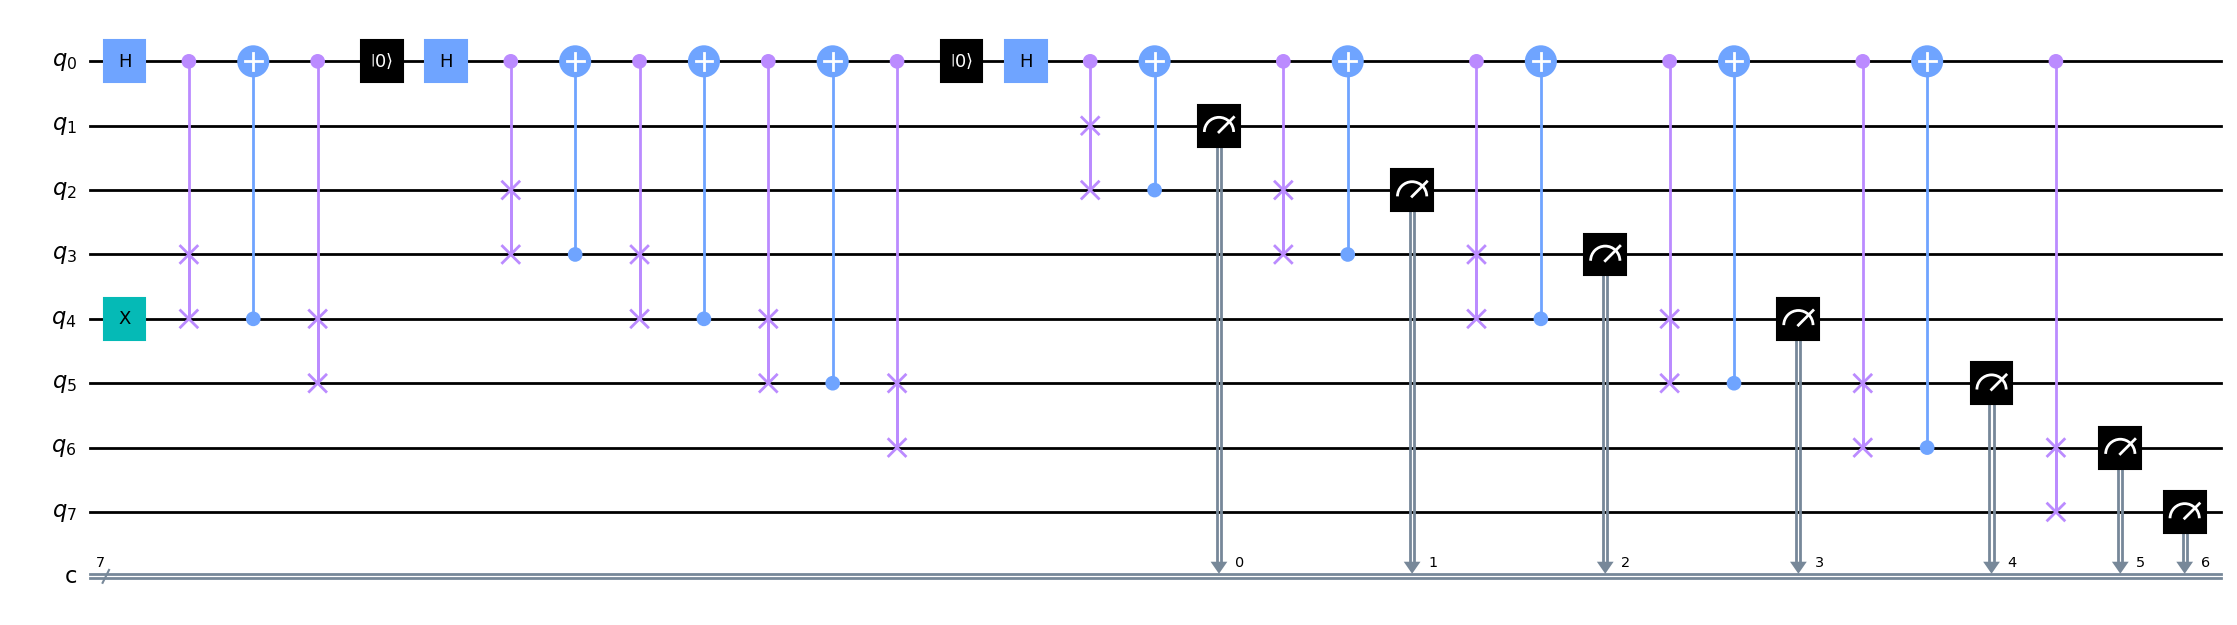

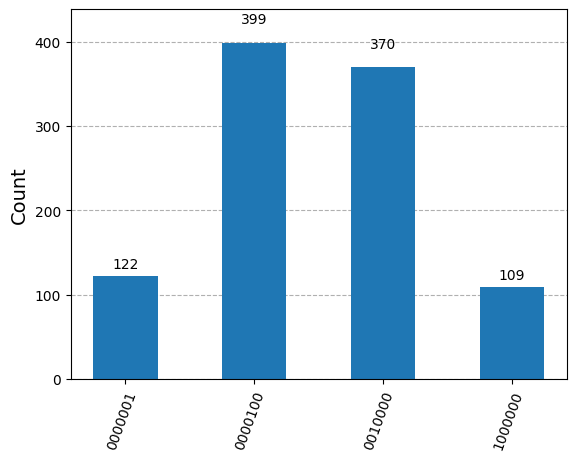

In [107]:

qc = QuantumCircuit(8, 7)

# Initial position: place particle at center (q[4])
qc.x(4)

# === Layer 1 ===
qc.h(0)                             # Hadamard on coin
qc.append(CSwapGate(), [0, 3, 4])   # swap q2 and q3 if coin is 1
qc.cx(4, 0)
qc.append(CSwapGate(), [0, 4, 5])   # swap q3 and q4 if coin is 1

# === Reset coin qubit (q[0]) to |0⟩ ===
qc.reset(0)

# === Layer 2 ===
qc.h(0)
qc.append(CSwapGate(), [0, 2, 3])
qc.cx(3, 0)
qc.append(CSwapGate(), [0, 3, 4])
qc.cx(4, 0)
qc.append(CSwapGate(), [0, 4, 5])
qc.cx(5, 0)
qc.append(CSwapGate(), [0, 5, 6])

# === Reset coin qubit (q[0]) to |0⟩ ===
qc.reset(0)

# === Layer 3 ===
qc.h(0)
qc.append(CSwapGate(), [0, 1, 2])
qc.cx(2, 0)
qc.append(CSwapGate(), [0, 2, 3])
qc.cx(3, 0)
qc.append(CSwapGate(), [0, 3, 4])
qc.cx(4, 0)
qc.append(CSwapGate(), [0, 4, 5])
qc.cx(5, 0)
qc.append(CSwapGate(), [0, 5, 6])
qc.cx(6, 0)
qc.append(CSwapGate(), [0, 6, 7])

# Measure relevant position qubits 
qc.measure(1, 0)  
qc.measure(2, 1) 
qc.measure(3, 2)  
qc.measure(4, 3) # center
qc.measure(5, 4)  
qc.measure(6, 5)
qc.measure(7, 6)

# Visualize circuit
qc.draw(output='mpl', style='clifford', fold = 1)
plt.show()

# Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=1000).result()
counts = result.get_counts()
plot_histogram(counts)
plt.show()


n - layer QGB generalisation

n_layers = 3
Total qubits (including coin): 8
Position bins: 7
SWAP gates: 9
CNOT gates: 6


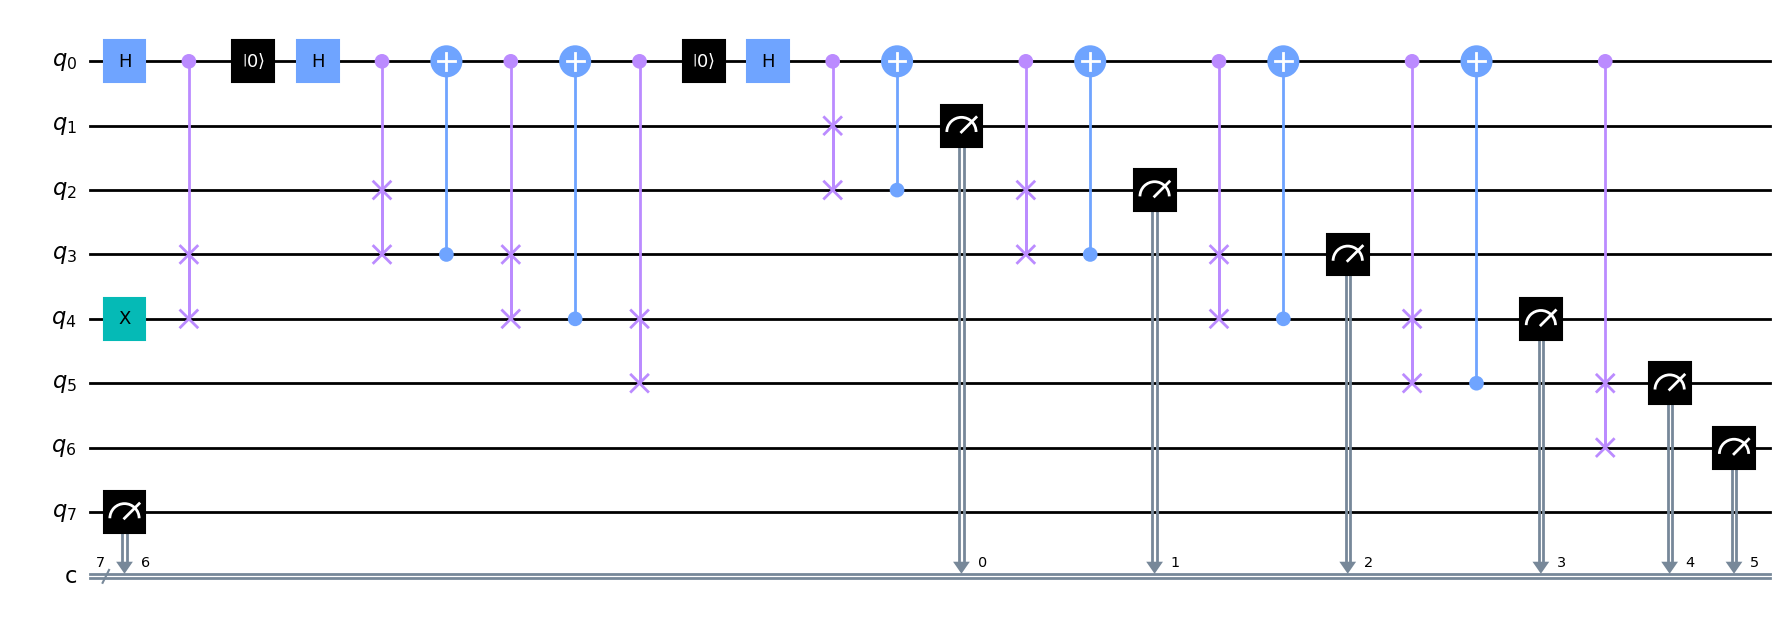

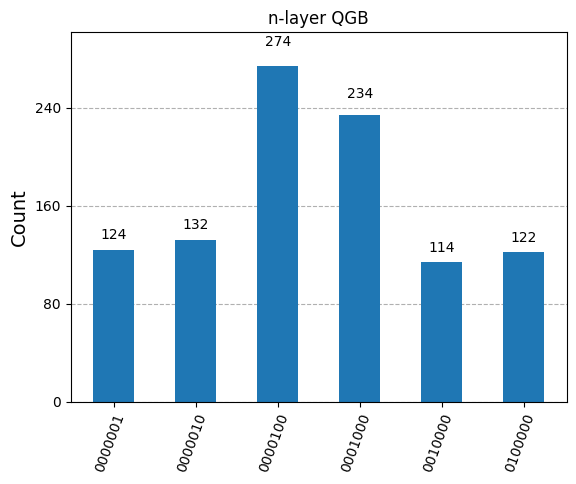

In [108]:
def qgb_n_layers(n_layers):
    
    n_pos = 2 * n_layers + 1
    n_qubits = 1 + n_pos  # 1 coin + position qubits
    qc = QuantumCircuit(n_qubits, n_pos)

    coin = 0
    pos = list(range(1, n_pos + 1))
    center = n_pos // 2

    # Initialize ball at center
    qc.x(pos[center])

    swap_count = 0
    cnot_count = 0

    for layer in range(1, n_layers + 1):
        qc.h(coin)
        # Leftmost to rightmost swaps for this layer
        for i in range(center - layer + 1, center + layer):
            qc.append(CSwapGate(), [coin, pos[i - 1], pos[i]])
            swap_count += 1
            # Add CNOT for interference except after last CSWAP in this layer
            if i < center + layer - 1:
                qc.cx(pos[i], coin)
                cnot_count += 1
        # Reset coin for next layer (except after last layer)
        if layer < n_layers:
            qc.reset(coin)

    # Measure all position qubits
    for i in range(n_pos):
        qc.measure(pos[i], i)

    print(f"n_layers = {n_layers}")
    print(f"Total qubits (including coin): {n_qubits}")
    print(f"Position bins: {n_pos}")
    print(f"SWAP gates: {swap_count}")
    print(f"CNOT gates: {cnot_count}")

    return qc

# Example usage for 3 layers:
qc = qgb_n_layers(3)
qc.draw(output='mpl', style='clifford', fold=1)

# Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=1000).result()
counts = result.get_counts()
plot_histogram(counts)
plt.title("n-layer QGB")
plt.show()

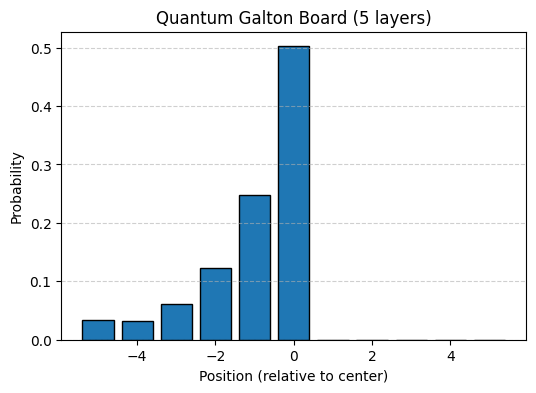

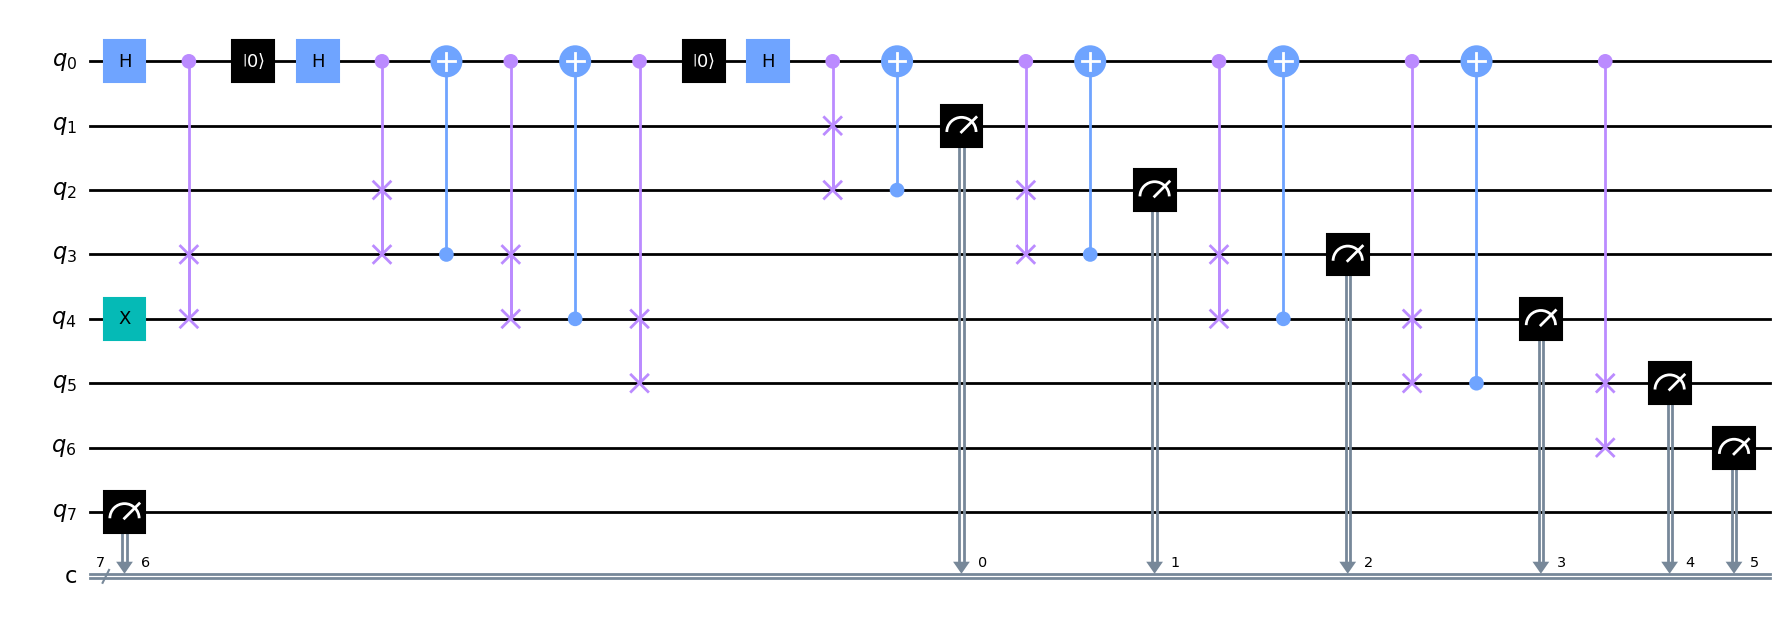

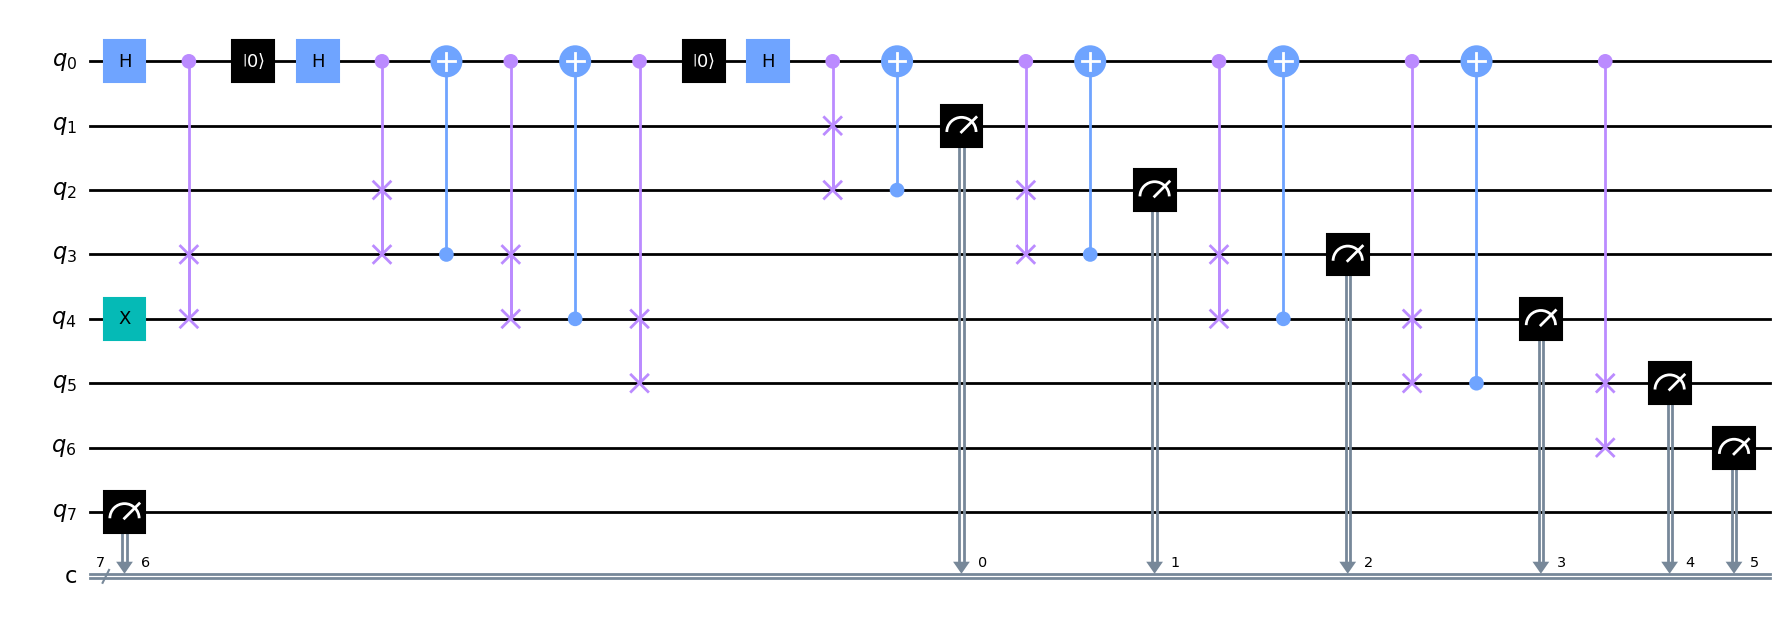

In [109]:
import math
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import CSwapGate
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

def generate_galton_circuit(n_layers: int) -> QuantumCircuit:
    """
    Build an n-layer quantum Galton board using one-hot encoding,
    with a fresh coin qubit for each layer (to avoid reset).
    - coin qubits: q[0] ... q[n_layers-1]
    - position qubits: q[n_layers] ... q[n_layers + (2*n_layers+1) - 1]
    - classical bits: 2*n_layers + 1
    """
    n_pos = 2*n_layers + 1
    total_qubits = n_layers + n_pos
    qc = QuantumCircuit(total_qubits, n_pos)

    # offset where position register begins
    pos0 = n_layers
    center = n_layers  # center index in the pos register

    # Initialize the walker at the center position
    qc.x(pos0 + center)

    # For each layer, use a fresh coin qubit
    for layer in range(n_layers):
        coin = layer
        # 1) coin flip
        qc.h(coin)
        # 2) conditional left move: swap center-(layer) <-> center-(layer+1)
        qc.append(
            CSwapGate(),
            [coin,
             pos0 + center - layer,
             pos0 + center - layer - 1]
        )
        # 3) conditional right move: swap center+layer <-> center+layer+1
        qc.append(
            CSwapGate(),
            [coin,
             pos0 + center + layer,
             pos0 + center + layer + 1]
        )
        # leave coin untouched thereafter

    # Measure all position qubits into classical bits [0..n_pos-1]
    for i in range(n_pos):
        qc.measure(pos0 + i, i)

    return qc

def run_and_plot(n_layers: int, shots: int = 2048):
    """
    Generate, simulate, and plot the output distribution
    of the n-layer quantum Galton board.
    """
    qc = generate_galton_circuit(n_layers)
    sim = AerSimulator()
    qc_compiled = transpile(qc, sim)
    counts = sim.run(qc_compiled, shots=shots).result().get_counts()

    # Convert one-hot counts → position histogram
    n_pos = 2*n_layers + 1
    pos_counts = [0]*n_pos
    for bitstr, cnt in counts.items():
        # Qiskit bitstr is c[n_pos-1]...c[0]; we wrote c[i]←pos0+i
        # Find which classical bit is '1'
        # Rightmost bit of bitstr is c[0], next is c[1], etc.
        for i in range(n_pos):
            if bitstr[-1 - i] == '1':
                pos_counts[i] += cnt
                break

    # Normalize
    total = sum(pos_counts)
    pos_probs = [c/total for c in pos_counts]

    # Plot
    positions = list(range(-n_layers, n_layers+1))
    plt.figure(figsize=(6,4))
    plt.bar(positions, pos_probs, edgecolor='k')
    plt.xlabel('Position (relative to center)')
    plt.ylabel('Probability')
    plt.title(f'Quantum Galton Board ({n_layers} layers)')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

    return pos_probs

if __name__ == "__main__":
    # Try it for 5 layers
    run_and_plot(n_layers=5, shots=4096)
    
qc.draw(output='mpl', style='clifford', fold=1)
